In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keys import api, secret
from pybit.unified_trading import HTTP


session = HTTP(
    api_key=api,
    api_secret=secret)

session = HTTP(api_key=api, api_secret=secret)


C:\Users\oyomi01\AppData\Local\Temp\ipykernel_27940\2941208037.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:

def get_klines():
    try:
        resp = session.get_kline(
            category='linear',
            symbol='BTCUSDT',
            interval=1,
            limit=750
        )['result']['list']
        df = pd.DataFrame(resp)
        df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']
        df = df.set_index('Time').astype(float).iloc[::-1]
        return df
    except Exception as e:
        print(f"Error fetching klines: {e}")
        return None

In [4]:
df=get_klines()
ema_12 = df['Close'].ewm(span=12, min_periods=12).mean()
ema_26 = df['Close'].ewm(span=26, min_periods=26).mean()
macd_line = ema_12 - ema_26
signal_line = macd_line.ewm(span=9, min_periods=9).mean()
df['MACD'] = macd_line
df['Signal_Line'] = signal_line

# Calculate 200-period Moving Average
df['200_MA'] = df['Close'].rolling(window=200).mean()

In [5]:
# Generate buy/sell signals
df['Buy_Signal'] = (df['MACD'] > df['Signal_Line']) & (df['Close'] > df['200_MA'])&(df['MACD']>5)
df['Sell_Signal'] = (df['MACD'] < df['Signal_Line']) & (df['Close'] < df['200_MA'])&(df['MACD']>-5)


In [6]:
# Implement trading strategy
df['Position'] = np.where((df['MACD'] > df['Signal_Line']) & (df['Close'] > df['200_MA']), 1, 0)
df['Position'] = np.where((df['MACD'] < df['Signal_Line']) & (df['Close'] < df['200_MA']), -1, df['Position'])

# Calculate returns
df['Returns'] = df['Close'].pct_change() * df['Position'].shift(1)


In [7]:

# Calculate returns
df['Returns'] = df['Close'].pct_change() * df['Position'].shift(1)

# Print cumulative returns
cumulative_returns = (df['Returns'] + 1).cumprod() - 1
print("Cumulative Returns:", cumulative_returns.iloc[-1])

Cumulative Returns: 0.0007248947076614609


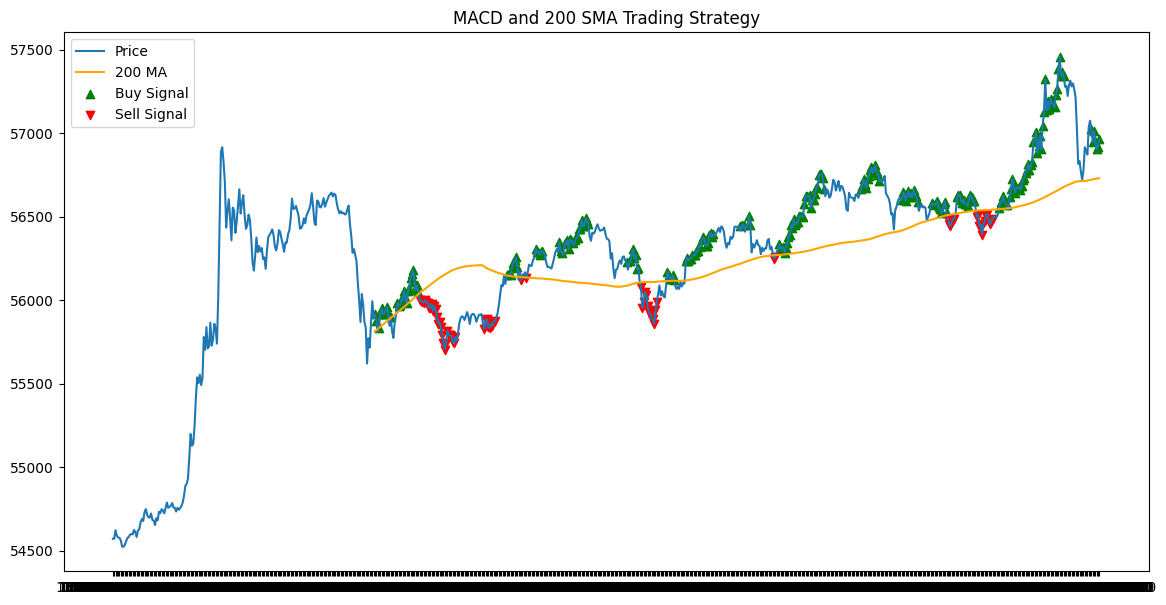

In [8]:
# Plot results
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Price')
plt.plot(df['200_MA'], label='200 MA', color='orange')
plt.scatter(df[df['Position'] == 1].index, df[df['Position'] == 1]['Close'], label='Buy Signal', marker='^', color='g')
plt.scatter(df[df['Position'] == -1].index, df[df['Position'] == -1]['Close'], label='Sell Signal', marker='v', color='r')
plt.legend()
plt.title('MACD and 200 SMA Trading Strategy')
plt.show()

In [9]:
def backtest_strategy(data):
    initial_capital = 10000 # Initial capital in USD
    capital = initial_capital
    position = 0  # 0: No position, 1: Long position, -1: Short position
    buy_price = 0
    sell_price = 0
    trades = []

    for i in range(1, len(data)):
        if data['Buy_Signal'][i] and position == 0:
            position = 1
            buy_price = data['Close'][i]
            capital -= buy_price
        elif data['Sell_Signal'][i] and position == 1:
            position = 0
            sell_price = data['Close'][i]
            capital += sell_price
            trades.append((buy_price, sell_price))

    # Calculate final capital and returns
    final_value = capital + (position * data['Close'].iloc[-1])
    returns = (final_value - initial_capital) / initial_capital * 100

    return final_value, returns, trades


In [10]:
data=get_klines()
data['200_MA'] = data['Close'].rolling(window=200).mean()

# Calculate MACD and Signal line
data['MACD'], data['Signal'] = calculate_macd(data)

# Generate buy/sell signals with stop loss and take profit
data['Buy_Signal'], data['Sell_Signal'] = generate_signals(data)

# Perform backtesting
final_value, returns, trades = backtest_strategy(data)

print("Final Portfolio Value: $", final_value)
print("Total Return: ", returns, "%")

NameError: name 'calculate_macd' is not defined

In [ ]:
# Plotting
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['200_MA'], label='200-day MA', alpha=0.5)
plt.scatter(data.index[data['Buy_Signal']], data['Close'][data['Buy_Signal']], marker='^', color='g', label='Buy Signal')
plt.scatter(data.index[data['Sell_Signal']], data['Close'][data['Sell_Signal']], marker='v', color='r', label='Sell Signal')
plt.title('Enhanced Crypto Trading Strategy with MACD, 200-day MA, Stop Loss, and Take Profit')
plt.legend()
plt.show()

In [17]:
def get_tp_spl(expected_profit,expected_loss,amount,price):
    expected_profit =25
    expected_loss =expected_profit/3
    init_price =10
    amount =200
    qty=amount/init_price

    perct_increae= (expected_profit/amount)
    perct_decreae= (expected_loss/amount)

    tp =init_price*(1+perct_increae)
    sl =init_price*(1-perct_decreae)

    sq=qty

 
    print(tp,sl,sq)
    return (tp,sl,sq)
    
get_tp_spl()


    






11.25 9.583333333333334 20.0


(11.25, 9.583333333333334, 20.0)